# Customer Analytics in FMGC Industry (Part 2)
#### by Sooyeon Won

### Keywords 

- Marketing Mix 
- STP framework 
- Purchase Analytics 
- Predictive Analysis
- Price Elasticity
- Modeling Purchase Incidence

### Contents 

<ul>
<li><a href="#Introduction">1. Introduction</a></li> 
<li><a href="#Preparation">2. Data Preparation</a></li>
<li><a href="#Exploration">3. Data Exploration</a></li>
<li><a href="#Analysis">4. Data Analysis</a></li>
&emsp;4.1. Customer Analytics<br>
&emsp;4.2. Purchase Analytics <br>
&emsp;&emsp;&emsp;i. Descriptive Analyses by Segment <br>
&emsp;&emsp;&emsp;&emsp;&emsp; i-1. The Proportion of each Segment <br>
&emsp;&emsp;&emsp;&emsp;&emsp; i-2. Purchase Occasions and Purchase Incidences <br>
&emsp;&emsp;&emsp;&emsp;&emsp; i-3. Brand Chocie <br>
&emsp;&emsp;&emsp;&emsp;&emsp; i-4. Revenue Comparison between segments <br>
&emsp;&emsp;&emsp;ii. Predictive Analyses <br>
&emsp;&emsp;&emsp;&emsp;&emsp; ii-1. Modeling Purchase Incidence<br>
&emsp;&emsp;&emsp;&emsp;&emsp; ii-2. Modeling Brand Choice <br>
&emsp;&emsp;&emsp;&emsp;&emsp; ii-3. Modeling Purchase Quantity <br>
<li><a href="#Conclusion">5. Conclusion</a></li>
</ul>


## 4. Data Analysis
### 4.2. Purchase Analytics
- Data Preparation from Part 1
- ii. Predictive Analyses <br>
&emsp;&emsp;&emsp; **ii-1. Modeling Purchase Incidence**<br>
&emsp;&emsp;&emsp; ii-2. Modeling Brand Choice <br>
&emsp;&emsp;&emsp; ii-3. Modeling Purchase Quantity <br>

### Data Preparation from Part 1

In [1]:
# Import the relevant libraries 
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
import matplotlib.axes as axs
%matplotlib inline
plt.rc("font", size=14)
import seaborn as sns
sns.set()
sns.set(style="whitegrid", color_codes=True)

from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans 

# Import pickle in order to be able to load our pickled objects.
import pickle

In [2]:
# Load data
purchase_df = pd.read_csv('purchase data.csv', index_col = 0)

# Import Scaler, PCA, K-Means
scaler = pickle.load(open('scaler.pickle', 'rb'))
pca = pickle.load(open('pca.pickle', 'rb'))
kmeans_pca = pickle.load(open('kmeans_pca.pickle', 'rb'))

# Standardisation
features = purchase_df[['Sex', 'Marital status', 'Age', 'Education', 'Income', 'Occupation', 'Settlement size']]
purchase_segm_std = scaler.transform(features)
# Apply PCA
purchase_segm_pca = pca.transform(purchase_segm_std)
# Segment data
purchase_segm_kmeans_pca = kmeans_pca.predict(purchase_segm_pca)

# Create a copy of the data frame
purchase_predictors = purchase_df.copy()

# Add segment labels
purchase_predictors['Segment'] = purchase_segm_kmeans_pca
segment_dummies = pd.get_dummies(purchase_segm_kmeans_pca, prefix = 'Segment', prefix_sep = '_')
purchase_predictors = purchase_predictors.reset_index()
purchase_predictors = purchase_predictors.merge(segment_dummies, how='inner',
                                                left_on = purchase_predictors.index,
                                                right_on = segment_dummies.index)

In [3]:
df_pa = purchase_predictors.set_index('ID').iloc[:,1:].copy()
df_pa.head() # Data is ready to conduct predictive analysis 

,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,Price_4,...,Age,Education,Income,Occupation,Settlement size,Segment,Segment_0,Segment_1,Segment_2,Segment_3
ID,,,,,,,,,,,,,,,,,,,,,
200000001,1,0,0,0,0,0,1.59,1.87,2.01,2.09,...,47,1,110866,1,0,0,1,0,0,0
200000001,11,0,0,0,0,0,1.51,1.89,1.99,2.09,...,47,1,110866,1,0,0,1,0,0,0
200000001,12,0,0,0,0,0,1.51,1.89,1.99,2.09,...,47,1,110866,1,0,0,1,0,0,0
200000001,16,0,0,0,0,0,1.52,1.89,1.98,2.09,...,47,1,110866,1,0,0,1,0,0,0
200000001,18,0,0,0,0,0,1.52,1.89,1.99,2.09,...,47,1,110866,1,0,0,1,0,0,0


### ii. Predictive Analysis 
In this section, I mainly conduct predictive analytics. Using supervised learning algorithm I estimated price elasticities and predict their effects on revenue.
### ii-1. Modeling Purchase Incidence
&emsp; - Purchase Probability Model <br>
&emsp; - Price Elasticity of Purchase Probability <br>
&emsp; - Purchase Elasticites by Segments <br>
&emsp; - Purchase Probabilty with Promotion Feature  <br>

### Purchase Probability Model

In [4]:
# Import the Logistic Regression module from sk learn for the purchase probability model.
from sklearn.linear_model import LogisticRegression 

In [5]:
# Set input and output variables in order to predict
# Output is Incidence,  since I want to predict the purchase probability for the customers
output = df_pa['Incidence'] 
# The input is based on the average price of chocolate candy bars. 
inputs = pd.DataFrame()
inputs['Mean_Price'] =df_pa.iloc[:, 6:11].mean(axis=1)

In [6]:
# Create a Logistic Regression model using sk-learn. Then we fit the model with our X or price and our Y or incidence.
Logitmodel_purchase = LogisticRegression(solver = 'sag')
Logitmodel_purchase.fit(inputs, output)

LogisticRegression(solver='sag')

In [7]:
Logitmodel_purchase.coef_

array([[-2.34797846]])

> The coefficient for price is negative, indicating that with an increase in price, the purchase probability decreases. Intuitively, a decrease in price would lead to an increase in purchase probability. This model quantifies the exact relationship between price and probability of purchase.

### Price Elasticity of Purchase Probability 

In this section, I observed not only the direction, but also the magnitude of the effect of price on purchase probability, which is price elasticity. Price elasticity of purchase probability means the percentage change in purchase probability and response to a 1 % change in the respective aggregate price for the product category.

In [8]:
# Turn off scientific notation in pandas 
pd.set_option('display.float_format', lambda x: '%.2f' % x)
# Describe the prices for the five different brands, which is an important factor in determining purchase probability. 
# It informs the price range, for which we will be exploring purchase probability.
df_pa[['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']].describe()

,Price_1,Price_2,Price_3,Price_4,Price_5
count,58693.00,58693.00,58693.00,58693.00,58693.00
mean,1.39,1.78,2.01,2.16,2.65
std,0.09,0.17,0.05,0.09,0.10
min,1.10,1.26,1.87,1.76,2.11
25%,1.34,1.58,1.97,2.12,2.63
50%,1.39,1.88,2.01,2.17,2.67
75%,1.47,1.89,2.06,2.24,2.70
max,1.59,1.90,2.14,2.26,2.80


> The minimum price of chocolates is 1.10 dollars and the maximum price is 2.80. I expand this price range somewhat to gain a better understanding of how the purchase probabilities and the respective elasticities change. in this analysis I chose the price range between
0.5 and 3.5. 

In [9]:
# Introduce the price range in order to examine the purchase probability.
# Note that the price range between 0.5 and 3.49, which somewhat expands the actual observed price range [1.1, 2.8].  
price_range = np.arange(0.5, 3.5, 0.01)
price_range_df = pd.DataFrame(price_range)

In [10]:
# Predict the purchase probability for our newly defined price range. 
output_pred = Logitmodel_purchase.predict_proba(price_range_df)
# The result is a 2x300  array. The first column shows the probability for not purchasing the product, 
# The second the probability for purchase for each price point in our price range.
purchase_prob = output_pred[:][:, 1]

[Price Elasticity - Reference](https://365datascience.com/price-elasticity/)
$$ E = \beta*price*(1-Pr(Purchase)) $$ 

The elasticities explains how does demand for the product change with a given change in price.

In [11]:
price_elasticity = Logitmodel_purchase.coef_[:, 0] * price_range * (1 - purchase_prob)

In [12]:
# Create price elasticities master data frame.
# It will contain all the elasticities we calculate during the purchase analytics part of the course.
price_elasticities_df = pd.DataFrame({'Price_Point': price_range, 'Mean_PE': price_elasticity })
pd.options.display.max_columns = None
price_elasticities_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
Price_Point,0.50,0.51,0.52,0.53,0.54,0.55,0.56,0.57,0.58,0.59,0.60,0.61,0.62,0.63,0.64,0.65,0.66,0.67,0.68,0.69,0.70,0.71,0.72,0.73,0.74,0.75,0.76,0.77,0.78,0.79,0.80,0.81,0.82,0.83,0.84,0.85,0.86,0.87,0.88,0.89,0.90,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,1.00,1.01,1.02,1.03,1.04,1.05,1.06,1.07,1.08,1.09,1.10,1.11,1.12,1.13,1.14,1.15,1.16,1.17,1.18,1.19,1.20,1.21,1.22,1.23,1.24,1.25,1.26,1.27,1.28,1.29,1.30,1.31,1.32,1.33,1.34,1.35,1.36,1.37,1.38,1.39,1.40,1.41,1.42,1.43,1.44,1.45,1.46,1.47,1.48,1.49,1.50,1.51,1.52,1.53,1.54,1.55,1.56,1.57,1.58,1.59,1.60,1.61,1.62,1.63,1.64,1.65,1.66,1.67,1.68,1.69,1.70,1.71,1.72,1.73,1.74,1.75,1.76,1.77,1.78,1.79,1.80,1.81,1.82,1.83,1.84,1.85,1.86,1.87,1.88,1.89,1.90,1.91,1.92,1.93,1.94,1.95,1.96,1.97,1.98,1.99,2.00,2.01,2.02,2.03,2.04,2.05,2.06,2.07,2.08,2.09,2.10,2.11,2.12,2.13,2.14,2.15,2.16,2.17,2.18,2.19,2.20,2.21,2.22,2.23,2.24,2.25,2.26,2.27,2.28,2.29,2.30,2.31,2.32,2.33,2.34,2.35,2.36,2.37,2.38,2.39,2.40,2.41,2.42,2.43,2.44,2.45,2.46,2.47,2.48,2.49,2.50,2.51,2.52,2.53,2.54,2.55,2.56,2.57,2.58,2.59,2.60,2.61,2.62,2.63,2.64,2.65,2.66,2.67,2.68,2.69,2.70,2.71,2.72,2.73,2.74,2.75,2.76,2.77,2.78,2.79,2.80,2.81,2.82,2.83,2.84,2.85,2.86,2.87,2.88,2.89,2.90,2.91,2.92,2.93,2.94,2.95,2.96,2.97,2.98,2.99,3.00,3.01,3.02,3.03,3.04,3.05,3.06,3.07,3.08,3.09,3.10,3.11,3.12,3.13,3.14,3.15,3.16,3.17,3.18,3.19,3.20,3.21,3.22,3.23,3.24,3.25,3.26,3.27,3.28,3.29,3.30,3.31,3.32,3.33,3.34,3.35,3.36,3.37,3.38,3.39,3.40,3.41,3.42,3.43,3.44,3.45,3.46,3.47,3.48,3.49
Mean_PE,-0.10,-0.10,-0.10,-0.11,-0.11,-0.12,-0.12,-0.13,-0.13,-0.14,-0.14,-0.15,-0.15,-0.16,-0.17,-0.17,-0.18,-0.19,-0.19,-0.20,-0.21,-0.21,-0.22,-0.23,-0.24,-0.24,-0.25,-0.26,-0.27,-0.28,-0.29,-0.30,-0.31,-0.32,-0.33,-0.34,-0.35,-0.36,-0.37,-0.38,-0.39,-0.41,-0.42,-0.43,-0.44,-0.46,-0.47,-0.48,-0.50,-0.51,-0.53,-0.54,-0.56,-0.57,-0.59,-0.61,-0.62,-0.64,-0.66,-0.67,-0.69,-0.71,-0.73,-0.75,-0.77,-0.79,-0.81,-0.83,-0.85,-0.87,-0.89,-0.91,-0.94,-0.96,-0.98,-1.00,-1.03,-1.05,-1.08,-1.10,-1.13,-1.15,-1.18,-1.20,-1.23,-1.26,-1.29,-1.31,-1.34,-1.37,-1.40,-1.43,-1.46,-1.49,-1.52,-1.55,-1.58,-1.61,-1.64,-1.67,-1.70,-1.73,-1.77,-1.80,-1.83,-1.87,-1.90,-1.93,-1.97,-2.00,-2.04,-2.07,-2.11,-2.14,-2.18,-2.21,-2.25,-2.28,-2.32,-2.36,-2.39,-2.43,-2.47,-2.50,-2.54,-2.58,-2.61,-2.65,-2.69,-2.73,-2.77,-2.80,-2.84,-2.88,-2.92,-2.96,-2.99,-3.03,-3.07,-3.11,-3.15,-3.18,-3.22,-3.26,-3.30,-3.34,-3.38,-3.42,-3.45,-3.49,-3.53,-3.57,-3.61,-3.64,-3.68,-3.72,-3.76,-3.80,-3.83,-3.87,-3.91,-3.95,-3.98,-4.02,-4.06,-4.10,-4.13,-4.17,-4.21,-4.24,-4.28,-4.32,-4.35,-4.39,-4.43,-4.46,-4.50,-4.54,-4.57,-4.61,-4.64,-4.68,-4.71,-4.75,-4.78,-4.82,-4.85,-4.89,-4.92,-4.96,-4.99,-5.02,-5.06,-5.09,-5.13,-5.16,-5.19,-5.23,-5.26,-5.29,-5.33,-5.36,-5.39,-5.42,-5.46,-5.49,-5.52,-5.55,-5.59,-5.62,-5.65,-5.68,-5.71,-5.74,-5.77,-5.81,-5.84,-5.87,-5.90,-5.93,-5.96,-5.99,-6.02,-6.05,-6.08,-6.11,-6.14,-6.17,-6.20,-6.23,-6.26,-6.

> Now, we have the magnitude of price elasticities at each price point. The following plot shows the entire elasticity curve visually and how the elasticity changes compared to the price range as a function the price elasticity decreases as price increases.

Text(0.5, 1.0, 'Price Elasticity of Purchase Probability')

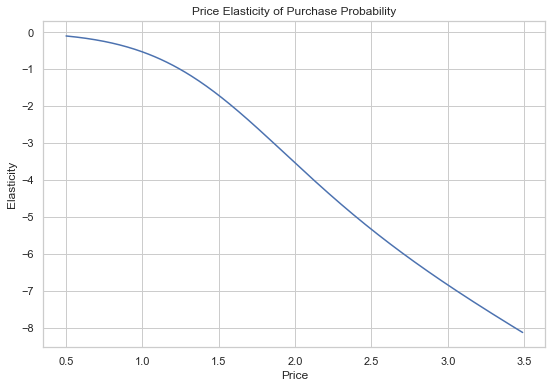

In [13]:
plt.figure(figsize= (9,6))
plt.plot(price_range, price_elasticity, color = 'b')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probability')

> Not surprisingly, the plot shows the higher the price of our product becomes the less likely it will be for people to want to buy it. 
>- The decrease in price is slow in the range between (0.5, 1.2), and then it becomes steeper after the point 1.1. 
>- The fact that the price elasticities are all negative is consistent with the negative model’s price coefficient: -2.34. 

> Note that "Elasticity" measures the percent change in an output variable by definition. If the percent change is greater than 100 percent, the output or purchase probability is called **"elastic"**. On the other hand, for changes less than 100 percent it is **"inelastic"**. In other words, if the elasticity has a value smaller than 1 in absolute terms we say it is **"inelastic"**. If it is greater than 1, it is **"elastic"**. <br> <br> 

>- For example, in the "price_elasticities_df" dataframe. the price elasticity at USD 1,10 price is -0.69. This means the average customer has an elasticity of -0.69. In other works, for each increase in price by 1 percent, the probability of purchase will change by -0.69 percent. 
>- The important observation here is that an increase of 1 percent in elasticity leads to a decrease of less than 1 percent.
Therefore purchase probability at this point is "inelastic". 
>- When we look at the 1.50 price the elasticity is -1.70. This implies that an increase of 1 percent in price would translate into a decline of -1.70 percent of purchase probability. Therefore an increase of 1 percent will lead to a decrease of almost 2 percent in purchase probability. In this case the elasticity of purchase probability is "elastic".
>- For inelastic values, the general recommendation is to increase the price as it wouldn't cause a significant decrease in the output variable or in our case purchase probability. On the other hand if we have elasticity which is greater than 1 in absolute terms, we should decrease the prices.
>-At the price 1,25, we can see that the price elasticity is -1.0. With prices lower than 1,25, we can increase our product price without losing too much in terms of purchase probability for prices higher than 1.25. We have more to gain by reducing our prices.  <br>
[Price Elasticity - Reference](https://365datascience.com/price-elasticity/)


So far, I have covered the elasticities of the purchase probability of the average customer in our dataset.
In the next section, I analyse how to obtain purchase elasticities for the different segments.

### Purchase Elasticites by Segments

#### Segment 0: Fewer-Opportunities

In [14]:
# Select only customers from segment 0, the standard segment.
segment_0 = df_pa.query('Segment == 0')

# Logistic regression model
output_segm0 = segment_0['Incidence']
inputs_segm0 = pd.DataFrame()
inputs_segm0['Mean_Price'] =segment_0.iloc[:, 6:11].mean(axis=1)

# Logistic regression model
model_incidence_segm0 = LogisticRegression(solver = 'sag')
model_incidence_segm0.fit(inputs_segm0, output_segm0)

# Calculate price elasticities
Y_segm0 = model_incidence_segm0.predict_proba(price_range_df)
purchase_prob_segm0 = Y_segm0[:][: , 1]
pe_segm0 = model_incidence_segm0.coef_[:,0] * price_range *( 1- purchase_prob_segm0)


In [15]:
model_incidence_segm0.coef_

array([[-3.60356767]])

#### Segment 1: Career-Focused 

In [16]:
# Filter the data to contain only customers from segment 1, the career-focused.
segment_1 = df_pa.query('Segment == 1')

# Again we want to predict the purchase probability, so our Y variable is the incidence column.
# Only here we select only the customers from the first segment.
output_segm1 = segment_1['Incidence']
inputs_segm1 = pd.DataFrame()
inputs_segm1['Mean_Price'] =segment_1.iloc[:, 6:11].mean(axis=1)

# Fit logistic regression model
model_incidence_segm1 = LogisticRegression(solver = 'sag')
model_incidence_segm1.fit(inputs_segm1, output_segm1)

# Calculate Price Elasticity of the career-focused segment.
Y_segm1 = model_incidence_segm1.predict_proba(price_range_df)
purchase_prob_segm1 = Y_segm1[:][:, 1]
pe_segm1 = model_incidence_segm1.coef_[:, 0] * price_range * (1 - purchase_prob_segm1)

In [17]:
# We observe that the price coefficient for the career focused is -1.7, whereas for the average customer it was -2.35.
# This is an indicator, that this segment is less price sensitive compared to the average customer.
model_incidence_segm1.coef_

array([[-1.72321388]])

#### Segment 2: Standard

In [18]:
# Select only customers from segment 2, the Standard.
segment_2 = df_pa.query('Segment == 2')

# Logistic regression model
output_segm2 = segment_2['Incidence']
inputs_segm2 = pd.DataFrame()
inputs_segm2['Mean_Price'] =segment_2.iloc[:, 6:11].mean(axis=1)

model_incidence_segm2 = LogisticRegression(solver = 'sag')
model_incidence_segm2.fit(inputs_segm2, output_segm2)

# Calculate price elasticities
Y_segm2 = model_incidence_segm2.predict_proba(price_range_df)
purchase_prob_segm2 = Y_segm2[:][: , 1]
pe_segm2 = model_incidence_segm2.coef_[:,0] * price_range * ( 1- purchase_prob_segm2)

In [19]:
model_incidence_segm2.coef_

array([[-1.50818787]])

#### Segment 3: Well-Off

In [20]:
# Select only customers from segment 0, the standard segment.
segment_3 = df_pa.query('Segment == 3')

# Logistic regression model
output_segm3 = segment_3['Incidence']
inputs_segm3 = pd.DataFrame()
inputs_segm3['Mean_Price'] =segment_3.iloc[:, 6:11].mean(axis=1)

# Logistic regression model
model_incidence_segm3 = LogisticRegression(solver = 'sag')
model_incidence_segm3.fit(inputs_segm3, output_segm3)

# Calculate price elasticities
Y_segm3 = model_incidence_segm3.predict_proba(price_range_df)
purchase_prob_segm3 = Y_segm3[:][: , 1]
pe_segm3 = model_incidence_segm3.coef_[:,0] * price_range *( 1- purchase_prob_segm3)


In [21]:
model_incidence_segm3.coef_

array([[-1.28489355]])

In [22]:
df_price_elasticities = pd.DataFrame({'Price_Point': price_range, 
                                      'Mean_PE': price_elasticity,
                                      'PE_Segment_0_FO': pe_segm0, 
                                      'PE_Segment_1_Cf': pe_segm1, 
                                      'PE_Segment_2_Strd': pe_segm2, 
                                      'PE_Segment_3_WO': pe_segm3})

df_price_elasticities.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
Price_Point,0.50,0.51,0.52,0.53,0.54,0.55,0.56,0.57,0.58,0.59,0.60,0.61,0.62,0.63,0.64,0.65,0.66,0.67,0.68,0.69,0.70,0.71,0.72,0.73,0.74,0.75,0.76,0.77,0.78,0.79,0.80,0.81,0.82,0.83,0.84,0.85,0.86,0.87,0.88,0.89,0.90,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,1.00,1.01,1.02,1.03,1.04,1.05,1.06,1.07,1.08,1.09,1.10,1.11,1.12,1.13,1.14,1.15,1.16,1.17,1.18,1.19,1.20,1.21,1.22,1.23,1.24,1.25,1.26,1.27,1.28,1.29,1.30,1.31,1.32,1.33,1.34,1.35,1.36,1.37,1.38,1.39,1.40,1.41,1.42,1.43,1.44,1.45,1.46,1.47,1.48,1.49,1.50,1.51,1.52,1.53,1.54,1.55,1.56,1.57,1.58,1.59,1.60,1.61,1.62,1.63,1.64,1.65,1.66,1.67,1.68,1.69,1.70,1.71,1.72,1.73,1.74,1.75,1.76,1.77,1.78,1.79,1.80,1.81,1.82,1.83,1.84,1.85,1.86,1.87,1.88,1.89,1.90,1.91,1.92,1.93,1.94,1.95,1.96,1.97,1.98,1.99,2.00,2.01,2.02,2.03,2.04,2.05,2.06,2.07,2.08,2.09,2.10,2.11,2.12,2.13,2.14,2.15,2.16,2.17,2.18,2.19,2.20,2.21,2.22,2.23,2.24,2.25,2.26,2.27,2.28,2.29,2.30,2.31,2.32,2.33,2.34,2.35,2.36,2.37,2.38,2.39,2.40,2.41,2.42,2.43,2.44,2.45,2.46,2.47,2.48,2.49,2.50,2.51,2.52,2.53,2.54,2.55,2.56,2.57,2.58,2.59,2.60,2.61,2.62,2.63,2.64,2.65,2.66,2.67,2.68,2.69,2.70,2.71,2.72,2.73,2.74,2.75,2.76,2.77,2.78,2.79,2.80,2.81,2.82,2.83,2.84,2.85,2.86,2.87,2.88,2.89,2.90,2.91,2.92,2.93,2.94,2.95,2.96,2.97,2.98,2.99,3.00,3.01,3.02,3.03,3.04,3.05,3.06,3.07,3.08,3.09,3.10,3.11,3.12,3.13,3.14,3.15,3.16,3.17,3.18,3.19,3.20,3.21,3.22,3.23,3.24,3.25,3.26,3.27,3.28,3.29,3.30,3.31,3.32,3.33,3.34,3.35,3.36,3.37,3.38,3.39,3.40,3.41,3.42,3.43,3.44,3.45,3.46,3.47,3.48,3.49
Mean_PE,-0.10,-0.10,-0.10,-0.11,-0.11,-0.12,-0.12,-0.13,-0.13,-0.14,-0.14,-0.15,-0.15,-0.16,-0.17,-0.17,-0.18,-0.19,-0.19,-0.20,-0.21,-0.21,-0.22,-0.23,-0.24,-0.24,-0.25,-0.26,-0.27,-0.28,-0.29,-0.30,-0.31,-0.32,-0.33,-0.34,-0.35,-0.36,-0.37,-0.38,-0.39,-0.41,-0.42,-0.43,-0.44,-0.46,-0.47,-0.48,-0.50,-0.51,-0.53,-0.54,-0.56,-0.57,-0.59,-0.61,-0.62,-0.64,-0.66,-0.67,-0.69,-0.71,-0.73,-0.75,-0.77,-0.79,-0.81,-0.83,-0.85,-0.87,-0.89,-0.91,-0.94,-0.96,-0.98,-1.00,-1.03,-1.05,-1.08,-1.10,-1.13,-1.15,-1.18,-1.20,-1.23,-1.26,-1.29,-1.31,-1.34,-1.37,-1.40,-1.43,-1.46,-1.49,-1.52,-1.55,-1.58,-1.61,-1.64,-1.67,-1.70,-1.73,-1.77,-1.80,-1.83,-1.87,-1.90,-1.93,-1.97,-2.00,-2.04,-2.07,-2.11,-2.14,-2.18,-2.21,-2.25,-2.28,-2.32,-2.36,-2.39,-2.43,-2.47,-2.50,-2.54,-2.58,-2.61,-2.65,-2.69,-2.73,-2.77,-2.80,-2.84,-2.88,-2.92,-2.96,-2.99,-3.03,-3.07,-3.11,-3.15,-3.18,-3.22,-3.26,-3.30,-3.34,-3.38,-3.42,-3.45,-3.49,-3.53,-3.57,-3.61,-3.64,-3.68,-3.72,-3.76,-3.80,-3.83,-3.87,-3.91,-3.95,-3.98,-4.02,-4.06,-4.10,-4.13,-4.17,-4.21,-4.24,-4.28,-4.32,-4.35,-4.39,-4.43,-4.46,-4.50,-4.54,-4.57,-4.61,-4.64,-4.68,-4.71,-4.75,-4.78,-4.82,-4.85,-4.89,-4.92,-4.96,-4.99,-5.02,-5.06,-5.09,-5.13,-5.16,-5.19,-5.23,-5.26,-5.29,-5.33,-5.36,-5.39,-5.42,-5.46,-5.49,-5.52,-5.55,-5.59,-5.62,-5.65,-5.68,-5.71,-5.74,-5.77,-5.81,-5.84,-5.87,-5.90,-5.93,-5.96,-5.99,-6.02,-6.05,-6.08,-6.11,-6.14,-6.17,-6.20,-6.23,-6.26,-6.

### Results

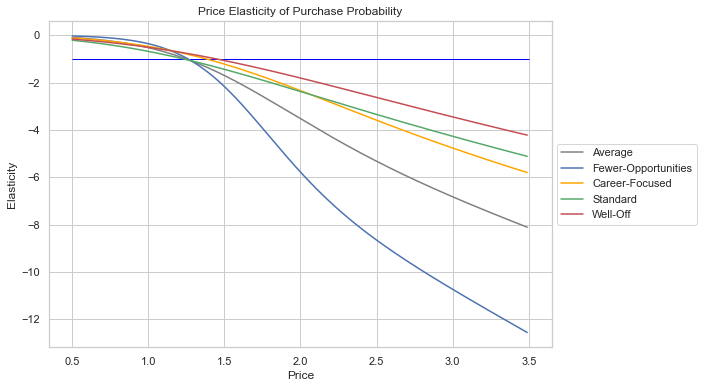

In [23]:
# We display all elasticities of purchase probability on the same plot. 
plt.figure(figsize = (9, 6))
ax1=plt.plot(price_range, price_elasticity, color = 'grey', label="Average")
ax2=plt.plot(price_range, pe_segm0, color = 'b', label='Fewer-Opportunities')
ax3=plt.plot(price_range, pe_segm1, color = 'orange', label='Career-Focused')
ax4=plt.plot(price_range, pe_segm2, color = 'g', label='Standard')
plt.plot(price_range, pe_segm3, color = 'r', label='Well-Off')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probability')
plt.hlines(y =-1.0, color='blue', linewidth=1, xmin = 0.5, xmax = 3.5)
# show the legend
plt.legend( bbox_to_anchor = (1, 0.5), loc = 6)
plt.show()

>- It seems that **"Fewer Opportunities"** segment is the most price sensitive compared to the average as well as other segments. The line is not only lower but it is also much steeper. And this means that with an increase in price they become more and more elastic much faster.

>- When we see the tipping point between elasticity and in elasticity for the **"Fewer-Opportunities"** segment, it seems to stand at 1,70. Considering the average tipping point was at 1,25, this is quite interesting. This indicates that this segment is more inelastic at lower prices. This is also evident from the graph. The Blue line ("Fewer-Opportunities") is a bit higher than the other two in the beginning. Later on however it becomes much steeper. 
    - The first reason could be technical since the fewer opportunities cluster is the biggest one may maybe the abundance of data is resulting in a more sophisticated model.
    - Second reason could be related to purchasing behavior. Maybe the fewer opportunities customer enjoys chocolate candy bars so much that a price increase in the lower price ranges won't stop them from buying it. However once it starts becoming expensive it does not make any financial sense to them to invest in it. 
    
>- We observe that the **"Well-Off"** segment is the least elastic across the price range, when compared to the rest. Their purchase probability elasticity is the least affected by price.

### Purchase Probabilty with Promotion Feature 

In [24]:
# Include a second promotion feature. We'd like to examine the effects of promotions on purchase probability.
# Calculate the average promotion rate across the five brands. We add the mean price for the brands.
output_prom = df_pa['Incidence']
inputs_prom = pd.DataFrame()
inputs_prom['Mean_Price'] =df_pa.iloc[:, 6:11].mean(axis=1)
inputs_prom['Mean_Promotion'] =df_pa.iloc[:, 11:16].mean(axis=1)

In [25]:
inputs_prom.head()

,Mean_Price,Mean_Promotion
ID,,
200000001,2.04,0.20
200000001,2.03,0.00
200000001,2.03,0.00
200000001,2.03,0.00
200000001,2.03,0.00


#### Model Estimation

In [26]:
# The coefficient for promotion is positive. 
# Therefore, there is a positive relationship between promotion and purchase probability.
model_incidence_prom = LogisticRegression(solver = 'sag')
model_incidence_prom.fit(inputs_prom, output_prom)
model_incidence_prom.coef_

array([[-1.4941023 ,  0.56130371]])

### Price Elasticity with vs. without Promotion

In [27]:
# First create a data frame on which our model will predict. We need to include A price and promotion feature.
# First, I include the price range as the price feature. Then I include the promotion feature.
# Calculate price elasticities of purchase probability when we assume there is a promotion across at each price points.
price_elasticity_prom = pd.DataFrame({'Price_Range':price_range , 'Promotion': 1} )

# Purchase Probability with Promotion Model Prediction
Y_promo = model_incidence_prom.predict_proba(price_elasticity_prom)
promo = Y_promo[:, 1]
price_elasticity_promo = (model_incidence_prom.coef_[:, 0] * price_range) * (1 - promo)

In [28]:
# Promotion feature - No Promotion.
# Assume there aren't any promotional activities on any of the price points.
# Examine the elasticity of purchase probability when there isn't promotion.
price_elasticity_no_promo = pd.DataFrame({'Price_Range':price_range , 'Promotion': 0} )

# Purchase Probability without Promotion Model Prediction
Y_no_promo = model_incidence_prom.predict_proba(price_elasticity_no_promo)
no_promo = Y_no_promo[: , 1]
price_elasticity_no_promo = model_incidence_prom.coef_[:, 0] * price_range *(1- no_promo)

In [29]:
# Update master data to include elasticities of purchase probability with promotion feature
df_price_elasticities['Elasticity_Promotion_1'] = price_elasticity_promo 
# Update master data frame to include purchase probability elasticities without promotion.
# We can now see the values with and without promotion and compare them for each price point in our price range.
df_price_elasticities['Elasticity_Promotion_0'] = price_elasticity_no_promo
price_elasticities = df_price_elasticities.T
price_elasticities.to_csv('price_elasticities.csv')
price_elasticities

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
Price_Point,0.50,0.51,0.52,0.53,0.54,0.55,0.56,0.57,0.58,0.59,0.60,0.61,0.62,0.63,0.64,0.65,0.66,0.67,0.68,0.69,0.70,0.71,0.72,0.73,0.74,0.75,0.76,0.77,0.78,0.79,0.80,0.81,0.82,0.83,0.84,0.85,0.86,0.87,0.88,0.89,0.90,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,1.00,1.01,1.02,1.03,1.04,1.05,1.06,1.07,1.08,1.09,1.10,1.11,1.12,1.13,1.14,1.15,1.16,1.17,1.18,1.19,1.20,1.21,1.22,1.23,1.24,1.25,1.26,1.27,1.28,1.29,1.30,1.31,1.32,1.33,1.34,1.35,1.36,1.37,1.38,1.39,1.40,1.41,1.42,1.43,1.44,1.45,1.46,1.47,1.48,1.49,1.50,1.51,1.52,1.53,1.54,1.55,1.56,1.57,1.58,1.59,1.60,1.61,1.62,1.63,1.64,1.65,1.66,1.67,1.68,1.69,1.70,1.71,1.72,1.73,1.74,1.75,1.76,1.77,1.78,1.79,1.80,1.81,1.82,1.83,1.84,1.85,1.86,1.87,1.88,1.89,1.90,1.91,1.92,1.93,1.94,1.95,1.96,1.97,1.98,1.99,2.00,2.01,2.02,2.03,2.04,2.05,2.06,2.07,2.08,2.09,2.10,2.11,2.12,2.13,2.14,2.15,2.16,2.17,2.18,2.19,2.20,2.21,2.22,2.23,2.24,2.25,2.26,2.27,2.28,2.29,2.30,2.31,2.32,2.33,2.34,2.35,2.36,2.37,2.38,2.39,2.40,2.41,2.42,2.43,2.44,2.45,2.46,2.47,2.48,2.49,2.50,2.51,2.52,2.53,2.54,2.55,2.56,2.57,2.58,2.59,2.60,2.61,2.62,2.63,2.64,2.65,2.66,2.67,2.68,2.69,2.70,2.71,2.72,2.73,2.74,2.75,2.76,2.77,2.78,2.79,2.80,2.81,2.82,2.83,2.84,2.85,2.86,2.87,2.88,2.89,2.90,2.91,2.92,2.93,2.94,2.95,2.96,2.97,2.98,2.99,3.00,3.01,3.02,3.03,3.04,3.05,3.06,3.07,3.08,3.09,3.10,3.11,3.12,3.13,3.14,3.15,3.16,3.17,3.18,3.19,3.20,3.21,3.22,3.23,3.24,3.25,3.26,3.27,3.28,3.29,3.30,3.31,3.32,3.33,3.34,3.35,3.36,3.37,3.38,3.39,3.40,3.41,3.42,3.43,3.44,3.45,3.46,3.47,3.48,3.49
Mean_PE,-0.10,-0.10,-0.10,-0.11,-0.11,-0.12,-0.12,-0.13,-0.13,-0.14,-0.14,-0.15,-0.15,-0.16,-0.17,-0.17,-0.18,-0.19,-0.19,-0.20,-0.21,-0.21,-0.22,-0.23,-0.24,-0.24,-0.25,-0.26,-0.27,-0.28,-0.29,-0.30,-0.31,-0.32,-0.33,-0.34,-0.35,-0.36,-0.37,-0.38,-0.39,-0.41,-0.42,-0.43,-0.44,-0.46,-0.47,-0.48,-0.50,-0.51,-0.53,-0.54,-0.56,-0.57,-0.59,-0.61,-0.62,-0.64,-0.66,-0.67,-0.69,-0.71,-0.73,-0.75,-0.77,-0.79,-0.81,-0.83,-0.85,-0.87,-0.89,-0.91,-0.94,-0.96,-0.98,-1.00,-1.03,-1.05,-1.08,-1.10,-1.13,-1.15,-1.18,-1.20,-1.23,-1.26,-1.29,-1.31,-1.34,-1.37,-1.40,-1.43,-1.46,-1.49,-1.52,-1.55,-1.58,-1.61,-1.64,-1.67,-1.70,-1.73,-1.77,-1.80,-1.83,-1.87,-1.90,-1.93,-1.97,-2.00,-2.04,-2.07,-2.11,-2.14,-2.18,-2.21,-2.25,-2.28,-2.32,-2.36,-2.39,-2.43,-2.47,-2.50,-2.54,-2.58,-2.61,-2.65,-2.69,-2.73,-2.77,-2.80,-2.84,-2.88,-2.92,-2.96,-2.99,-3.03,-3.07,-3.11,-3.15,-3.18,-3.22,-3.26,-3.30,-3.34,-3.38,-3.42,-3.45,-3.49,-3.53,-3.57,-3.61,-3.64,-3.68,-3.72,-3.76,-3.80,-3.83,-3.87,-3.91,-3.95,-3.98,-4.02,-4.06,-4.10,-4.13,-4.17,-4.21,-4.24,-4.28,-4.32,-4.35,-4.39,-4.43,-4.46,-4.50,-4.54,-4.57,-4.61,-4.64,-4.68,-4.71,-4.75,-4.78,-4.82,-4.85,-4.89,-4.92,-4.96,-4.99,-5.02,-5.06,-5.09,-5.13,-5.16,-5.19,-5.23,-5.26,-5.29,-5.33,-5.36,-5.39,-5.42,-5.46,-5.49,-5.52,-5.55,-5.59,-5.62,-5.65,-5.68,-5.71,-5.74,-5.77,-5.81,-5.84,-5.87,-5.90,-5.93,-5.96,-5.99,-6.02,-6.05,-6.08,-6.11,-6.14,-6.17,-6.20,-6.23,-6.26,-6.

### Result 

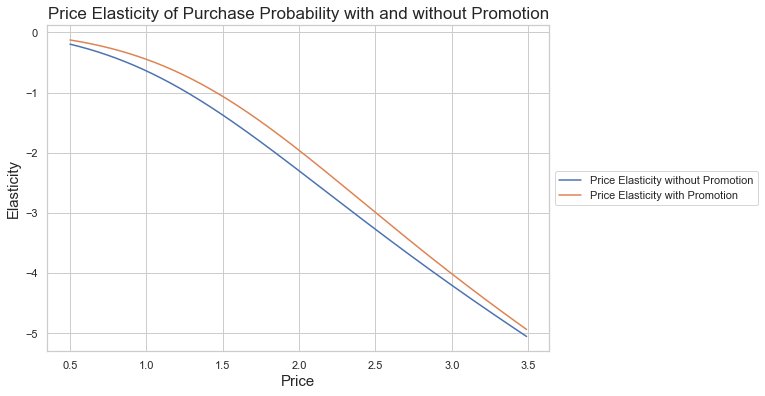

In [30]:
# Plot purchase elasticities with and without promotion.
plt.figure(figsize = (9, 6))
plt.plot(price_range, price_elasticity_no_promo, label = 'Price Elasticity without Promotion')
plt.plot(price_range, price_elasticity_promo, label = 'Price Elasticity with Promotion')
plt.xlabel('Price',fontsize =15)
plt.ylabel('Elasticity',fontsize =15)
plt.title('Price Elasticity of Purchase Probability with and without Promotion',fontsize =17)
# Show the legend
plt.legend( bbox_to_anchor = (1, 0.5), loc = 6)
plt.show()

> Note that the two lines in the graph represent the elasticity of purchase probability given maximum and given minimum promotional activity. This graph here tells us that the elasticity curve with promotion sits above its respective no promotion
counterpart for the entire price range. <br>
In addition, when we see the master data frame (df_price_elasticities), we can notice that in elasticity for no promotion ends at 1,27 dollors, while for promotion at 1,46. That's a difference of almost 20 cents.<br><br>
In other words, if a product has a regular price of 1,30 dollars, the purchase probability is elastic. However if a product cost 1,50 dollars on the regular and its price is reduced to the 1,30 dollars during a promotion, then my analysis says that purchase probability is still inelastic at this point.<br><br>
People are more willing to buy products at promotional prices be it because of the large discount signs in some stores or just because psychologically people feel they're getting a bargain. In any case customers are less price sensitive to similar price changes when there are promotion activities. It definitely pays off to offer discounts. It would be more beneficial to have a higher original price and constant promotion rather than a lower original price. 